# Assume everywhere that $h=1$

In [1]:
import numpy as np
import healpy as hp
import kmeans_radec
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic, powerlaw, binned_statistic_2d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.io import fits

import Setup as p

from scipy.constants import c as speed_of_light

h = 1

## Define some useful functions

In [2]:
def absmag2appmag_kcorrection(M, comoving_distance, redshift, Kcorr):
    luminosity_distance = (1+redshift)*comoving_distance
    return M+25+5*np.log10(luminosity_distance)+Kcorr

## Import the NSA catalog and apply some cuts

/mnt/zfsusers/rstiskalek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Retained 417147 galaxies, i.e. 65.04 %


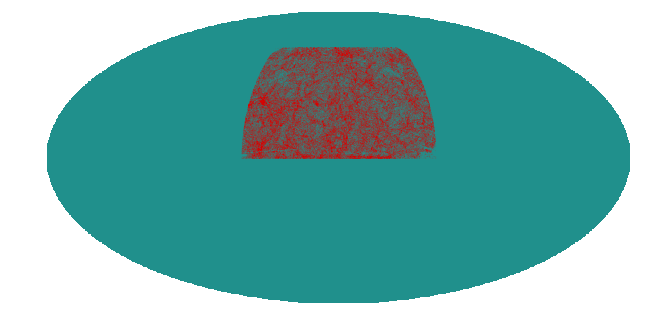

In [4]:
catalog = fits.open("../../BAM/Old/nsa_v1.fits")[1].data

# Unpack the catalog
MS = catalog['SERSIC_MASS']/h**2
RA = catalog['RA']
DEC = catalog['DEC']
ZDIST = catalog['ZDIST']
Z = catalog['Z']
Mr = catalog['SERSIC_ABSMAG'][:, 4]-5*np.log10(h)
Kcorr = catalog['SERSIC_KCORRECT'][:, 4]


apparent_magnitude = absmag2appmag_kcorrection(Mr, ZDIST*speed_of_light*1e-3/(h*100), Z, Kcorr)

# Take only objects within some sky location
IDS1 = np.where(np.logical_and(RA > 120, RA < 240))[0]
IDS2 = np.where(np.logical_and(DEC > 0, DEC < 60))[0]
# Take only objects with absmag estimate
IDS3 = np.where(np.isfinite(Mr))[0]
# Take only objects with a finite mass, larger than 0
IDS4 = np.where(np.logical_and(np.isfinite(MS), MS > 0))[0]
# Take only objects with apparent magnitude < 17.6
# IDS5 = np.where(np.logical_and(apparent_magnitude>14.5, apparent_magnitude < 17.6))
IDS5 = np.where(np.isfinite(apparent_magnitude))



IDS = np.intersect1d(np.intersect1d(np.intersect1d(IDS1, IDS2), np.intersect1d(IDS3, IDS4)), IDS5)


logMS = np.log10(MS[IDS])
RA = RA[IDS]
DEC = DEC[IDS]
ZDIST = ZDIST[IDS]
Z = Z[IDS]
Mr = Mr[IDS]
Kcorr = Kcorr[IDS]
apparent_magnitude = apparent_magnitude[IDS]

print("Retained {} galaxies, i.e. {:.2f} %".format(RA.size, RA.size/MS.size*100))


hp.mollview(np.zeros(12), rot=180, cbar=False, title='')
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.0001, c='red')
plt.show()

### Make a function to convert logMS to Mr (2 sigma value)

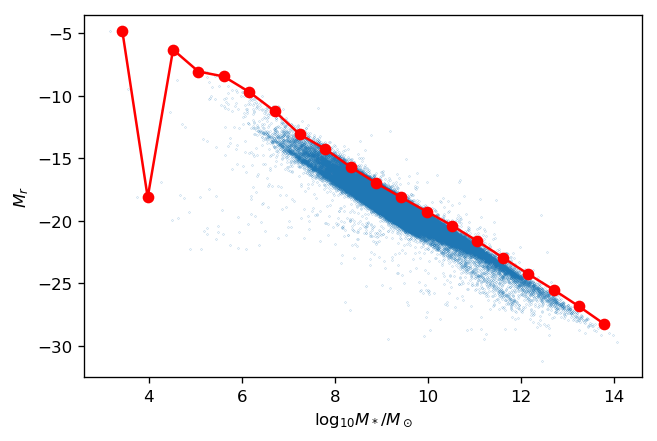

In [5]:
Nbins = 20
__, bin_edges, binnumber = binned_statistic(logMS, Mr, bins=Nbins, statistic='count')
binnumber = binnumber-1
bin_centers = p.bin_centers(bin_edges)

upper_bound = list()
for i in range(Nbins):
    IDS = np.where(binnumber==i)
    bin_values = Mr[IDS]
    N = bin_values.size
    ID = int(N*0.954499736) # Take object with magnitude corresponding to 2-sigma
    upper_bound.append(np.sort(bin_values)[ID])

upper_bound = np.array(upper_bound)
MS2absmag_func = interp1d(bin_centers, upper_bound)

plt.figure(dpi=120)
plt.scatter(logMS, Mr, s=0.01)
plt.plot(bin_centers, upper_bound, c='red', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$M_r$")
plt.show()

### Extrapolate the luminosity function

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


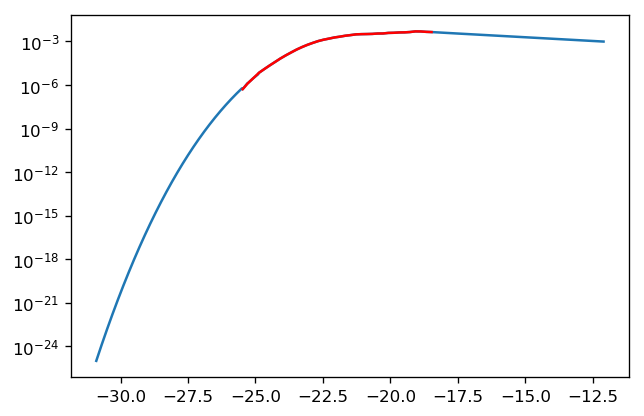

In [7]:
dataLF = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")
# In https://arxiv.org/pdf/1304.7778.pdf h=0.7. Convert to preferred hubble units.
xLF = dataLF[:, 0] + 5*np.log10(0.7)
yLF = dataLF[:, 1] #+ 3*np.log10(0.7)

# Extrapolate the faint and bright end
def bright_end_func(x, a, b, c, d): return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b): return a*x+b

xmax = 29
bright_end_coef = curve_fit(bright_end_func, xLF[:xmax], yLF[:xmax], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-3, None)
faint_end_coef = curve_fit(faint_end_func, xLF[s], yLF[s], [0, 0], maxfev=100000)[0]


tbright = np.arange(-24.7-0.2, -31, -0.2)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint = np.arange(-17.5, -12, 0.2)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

# Merge the arrays
xx = np.hstack([tfaint, xLF, tbright])
yy = np.hstack([yfaint, yLF, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

# Extrapolated luminosity function
nlum = interp1d(xx, 10**yy, kind='cubic')


plt.figure(dpi=120)
plt.semilogy(xx, 10**yy)
plt.semilogy(xLF, 10**yLF, c='red')
plt.show()

### Define some useful functions

$$\varphi(d)=\frac{\int_{M_{r, l i m}(d)}^{M_{r, \min }} n\left(M_{r}\right) d M_{r}}{\int_{M_{r, \max }}^{M_{r, \max }} n\left(M_{r}\right) d M_{r}}$$

In [ ]:
def redshift2distance(z):
    omega_m = 0.295
    omega_lambda = 0.705
    omega_k = 0.0
    H0 = h*100
    Dh = speed_of_light*1e-3/(H0)
    num = lambda z_prime : 1/np.sqrt(omega_m*(1+z_prime)**3+omega_k*(1+z_prime)**2+omega_lambda)
    quadnum = quad(num, 0, z)[0]
    comoving_distance = Dh*quadnum
    return comoving_distance

xx_redshift = np.linspace(0, 1, 10000)
yy_comoving = np.array([redshift2distance(i) for i in xx_redshift])

distance2redshift = interp1d(yy_comoving, xx_redshift)

def func_absmag(appmag, comoving_dist):
    # Return absolute magnitude for a given apparent magnitude and comoving distance
    z = distance2redshift(comoving_dist)
    luminosity_distance = (1+z)*comoving_dist
    return appmag-25-5*np.log10(luminosity_distance)


def surv_func(dist, Mmax, Mmin):
    Mlim = func_absmag(17.6, dist)
    if Mlim > Mmax:
        return 1
    else:
        norm = np.abs(quad(nlum, Mmax, Mmin)[0])
        num = np.abs(quad(nlum, Mlim, Mmin)[0])
        return num/norm

In [ ]:
gal_dists = ZDIST*speed_of_light*1e-3/(h*100)
comoving_dist_arr = np.linspace(gal_dists.min(), gal_dists.max(), 100)

plt.figure(dpi=120)
for masslim in [9.4, 9.8, 10.2, 10.6]:
    Mrmax = MS2absmag_func(masslim)
    y = np.array([surv_func(i, Mrmax, -25) for i in comoving_dist_arr])
    plt.plot(comoving_dist_arr, y, label=masslim)
plt.legend()
plt.show()

# Set $\log_{10}M_*$ !!!

In [ ]:
logMSlim = 9.8

IDS = np.where(logMS>logMSlim)

def proportion(x, Mr):
    return np.where(Mr < x)[0].size/Mr.size

x = np.linspace(Mr.min(), Mr.max(), 1000)
y = np.array([proportion(i, Mr[IDS]) for i in x])

target = 0.3

f = interp1d(y, x)
Mrmin = float(f(target))
print(Mrmin)

gal_dists = ZDIST*speed_of_light*1e-3/(h*100)

# Generate a random catalog
Nrands = int(1e6)

Pmin = (np.sin(np.deg2rad(DEC.min()))+1)/2
Pmax = (np.sin(np.deg2rad(DEC.max()))+1)/2
randRA = np.random.uniform(RA.min(), RA.max(), Nrands)
randDEC = np.rad2deg(np.arcsin(2*np.random.uniform(Pmin, Pmax, size=Nrands)-1))
randDist = powerlaw.rvs(a=3, loc=gal_dists.min(), scale=gal_dists.max()-gal_dists.min(), size=Nrands)

Mrmax = MS2absmag_func(logMSlim)
comoving_dist_arr = np.linspace(gal_dists.min(), gal_dists.max(), 250)
y = np.array([surv_func(i, Mrmax, -21.4) for i in comoving_dist_arr])
surv_interp = interp1d(comoving_dist_arr, y, kind='linear')


surv_prob = surv_interp(randDist)
rand_prob = np.random.uniform(0, 1, Nrands)
IDS = np.where(surv_prob>rand_prob)

randDist = randDist[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]



# # Cluster the galaxies for jackknifing
# N = randRA.size
# Ncluster = 15000
# IDS = np.random.choice(np.arange(N), Ncluster, False)
# X = np.vstack([randRA[IDS], randDEC[IDS]]).T
# km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

# X = np.vstack([randRA, randDEC]).T
# randLabels = km.find_nearest(X)
# print("Done with clustering.")

# hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
# for label in np.unique(km.labels):
#     IDSlab = np.where(km.labels==label)
#     hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)

    
IDS = np.where(logMS>logMSlim)

IDS2 = np.random.choice(np.arange(randDist.size), ZDIST[IDS].size, False)

plt.figure(dpi=120)
plt.hist(ZDIST[IDS]*speed_of_light*1e-3/100, bins=75)
plt.hist(randDist[IDS2], bins=75, alpha=0.5)

plt.show()

In [ ]:
# Nrands = randDist.size
# random_catalog = np.zeros(Nrands, dtype={'names':('ra', 'dec', 'cz', 'label', 'weights'),
#                                 'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
# random_catalog['ra'] = randRA
# random_catalog['dec'] = randDEC
# random_catalog['cz'] = randDist*(h*100)
# random_catalog['label'] = randLabels
# random_catalog['weights'] = np.ones_like(randRA)

# np.save("../../Data/NSAmatching/CFrandcatNSA_{}_.npy".format(logMSlim), random_catalog)
# print("We have {} galaxies in random with cut at {}.".format(Nrands, logMSlim))

# IDS = np.where(logMS>logMSlim)
# Ncat = ZDIST[IDS].size
# X = np.vstack([RA[IDS], DEC[IDS]]).T

# cut_catalog = np.zeros(Ncat, dtype={'names':('ra', 'dec', 'cz', 'weights', 'label'),
#                                 'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
# cut_catalog['ra'] = RA[IDS]
# cut_catalog['dec'] = DEC[IDS]
# cut_catalog['cz'] = ZDIST[IDS]*speed_of_light*1e-3
# cut_catalog['label'] = km.find_nearest(X)
# cut_catalog['weights'] = np.ones_like(RA[IDS])

# np.save("../../Data/NSAmatching/CFcatNSA_{}_.npy".format(logMSlim), cut_catalog)
# print("We have {} galaxies in observation.".format(Ncat))

# print("Random is {:.2f} bigger than observation".format(Nrands/Ncat))

# # hp.mollview(np.zeros(12), rot=180)
# # for label in np.unique(km.labels):
# #     IDSlab = np.where(label==cut_catalog['label'])
# #     hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)
    

In [8]:
DECmin = np.deg2rad(0)
DECmax = np.deg2rad(60)
RAmin = np.deg2rad(120)
RAmax = np.deg2rad(240)

a = xLF.min()
b = xLF.max()

Distmax = 200
volume = (np.sin(DECmax)-np.sin(DECmin))*(RAmax-RAmin)*1/3*(Distmax)**3

def expected_number(Mrmax):
    return quad(nlum, a, Mrmax)[0]*volume

distance = ZDIST*speed_of_light*1e-3/100
IDS = np.where(distance<Distmax)
Mr_volumelimited = Mr[IDS]

def volume_lim_number(Mrmax):
    return np.where(Mr_volumelimited < Mrmax)[0].size


In [10]:
a = Mr_volumelimited.min()
b = Mr_volumelimited.max()

bin_width = 0.2
bins = np.arange(-25.47, -18.47, bin_width)
bin_centers = p.bin_centers(bins)

stat, __, __ = binned_statistic(Mr_volumelimited, Mr_volumelimited, statistic='count', bins=bins)

stat = stat/bin_width/volume

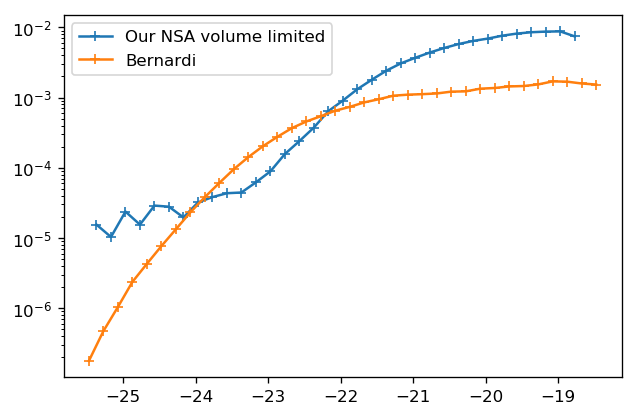

In [11]:
plt.figure(dpi=120)
plt.semilogy(bin_centers, stat, marker='+', label='Our NSA volume limited')
plt.semilogy(xLF, 10**yLF*0.7**3, marker='+', label='Bernardi')
plt.legend()
plt.savefig("../../Plots/DiffLFcomp.pdf")
plt.show()

In [ ]:
Mr_volumelimited.size

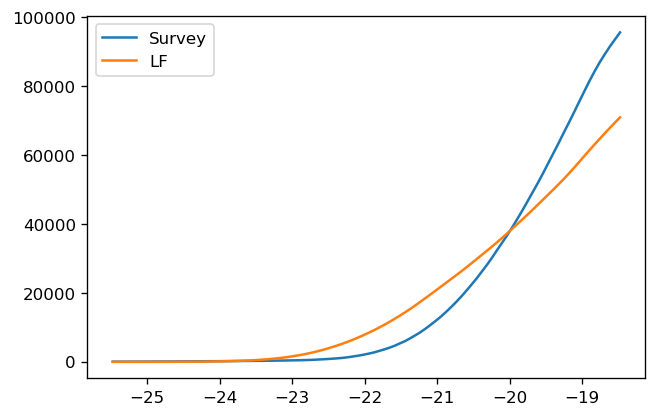

In [9]:
t = np.linspace(a, b, 100)
y = np.array([volume_lim_number(i) for i in t])
y2 = np.array([expected_number(i) for i in t])

plt.figure(dpi=120)
plt.plot(t,y, label='Survey')
plt.plot(t, y2, label='LF')
# plt.yscale('log')
plt.legend()
plt.savefig("../../Plots/ExpectedvsObservedNumber.pdf")
plt.show()

# Examine fiber collisions

In [ ]:
import itertools
from scipy.special import comb
import healpy

In [ ]:
def angular_separation(RA1, DEC1, RA2, DEC2):
    return np.arccos(np.sin(DEC1)*np.sin(DEC2)+np.cos(DEC1)*np.cos(DEC2)*np.cos(RA1-RA2))

In [ ]:
RArad = np.deg2rad(RA)
DECrad = np.deg2rad(DEC)

In [ ]:
comb(25000, 2)/comb(10000, 2)*26.3/60

In [ ]:
# N = RArad.size
N = 25000
arr = np.arange(N)

combs = list(itertools.combinations(arr, 2))
combs = np.array(combs)
min_sep = np.deg2rad(55/3600)


angsep = angular_separation(RArad[combs[:, 0]], DECrad[combs[:, 0]], RArad[combs[:, 1]], DECrad[combs[:, 1]])

IDS = np.where(min_sep > angsep)



In [ ]:
test = ZDIST[combs[IDS][:, 0]]-ZDIST[combs[IDS][:, 1]]

In [ ]:
plt.figure(dpi=120)
plt.hist(test, bins='auto')
plt.show()